**BÁO CÁO BÀI TẬP LỚN HỌC MÁY CUỐI KỲ**

Mã Lớp: INT3405_1

Họ và tên: Nguyễn Huy Hoàn

Mã số sinh viên:18020532

# Mô tả bài toán

Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác, những người đóng góp thông tin chi tiết độc đáo và câu trả lời chất lượng.Vì là một nền tảng mở ai cũng có thể đọc và hỏi đáp một cách dễ dàng nên sẽ có những người đưa ra những định kiến, những câu hỏi mang tính độc hại chia rẽ.

Thách thức ở đây là làm sao loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra dựa trên những tiền đề sai lầm hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích, qua đó cải thiện nền tảng để nó thành 1 nơi mà mọi người dễ dàng trao đổi hơn không bị ảnh hưởng bởi những toxic question như vậy nữa

input: câu hỏi dạng text

output: 1/0(không chân thành/ chân thành)

Phần 1: Các bước khảo sát dữ liêu, xây dựng mô hình.

Phần 2: Clean code với k-fold = 5.

# Phần 1

# Thư viện

In [ ]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

# Dữ liệu
## Chuẩn bị dữ liệu

In [ ]:
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
train.head()

In [ ]:
temp = train[train['target'] == 1]
temp.head()

In [ ]:
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
test.head()

In [ ]:
submission = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv')
submission.head()

## Tổng hợp và khảo sát dữ liệu

Kiểm tra thông tin không xác định

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
train.shape, test.shape

Kiểm tra số lượng target = 1

In [ ]:
df_train = train.drop(['qid', 'question_text'], axis = 1)
label_counts = df_train.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts

Tỉ lệ trực quan

In [ ]:
labels = np.round(df_train.sum()/len(df_train)*100, 1)
labels

### Kết quả khảo sát:
- Không có dữ liệu không xác định (null).
- Tập train có 1306122 giá trị, tập test có 375806 giá trị.
- Dữ liệu target = 1 có 80810 giá trị, chiếm khoảng 6.2% tập train.

## Chuẩn hóa dữ liệu

### Dọn dẹp dữ liệu:
Chúng ta cần dọn dẹp, mã hóa và chuyển đổi dữ liệu sang tensor.
Hàm bên dưới giúp chúng ta thực hiện:
- Xóa siêu liên kết, dấu chấm câu và số.
- Mã hóa.
- Bỏ qua việc thay đổi tất cả thành chữ thường và giữ cho các chữ cái phù hợp với từng trường hợp. "BAD !!" >> "bad !!".
- Không xóa các từ dừng, Vì với các mô hình ngữ cảnh như BERT và ROBERTA, tốt hơn hết là (hầu như) không xử lý các văn bản xóa từ dừng. Các mô hình này được đào tạo trước với các từ dừng: nếu loại bỏ các từ dừng, mô hình có thể mất ngữ cảnh. Điều này cũng đúng với các kỹ thuật tiền xử lý gốc và lemmatization. Vì vậy, ta cũng bỏ qua chúng!

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    #text = text.lower()
    
    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)
    
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #pattern = <, zero or more characters, >, (one or more occurance of >)
    text = re.sub('<.*?>+', '', text)
    
    #pattern = any punctionation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    #pattern = any new line
    text = re.sub('\n', '', text)
    
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)
    return text

Để giảm thời gian train, ta chỉ sử dụng 50000 giá trị

In [ ]:
%%time
train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv', nrows = 50000)
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
train['clean_text'] = train['question_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['question_text'].apply(str).apply(lambda x: clean_text(x))

Sử dụng 20% dữ liệu training làm bộ validation.

In [ ]:
kfold = 5
train['kfold'] = train.index % kfold
train.index % kfold

In [ ]:
p_train = train[train["kfold"] != 0].reset_index(drop = True)
p_valid = train[train["kfold"] == 0].reset_index(drop = True)

In [ ]:
p_train.head()

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
%%time
senten_len = []
for sentence in tqdm(p_train['clean_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

Xem xét sự phân bố độ dài cho các question_text được mã hóa để lựa chọn max_length cho các dữ liệu được mã hóa của chúng ta.

In [ ]:
sns.distplot(senten_len)
plt.xlim([0, 50])
plt.xlabel('Tocken count')

In [ ]:
max_len = 30

Định nghĩa lớp BertDataSet vói Dataset là siêu lớp và ghi đè hàm init, len và getitem. Nó sẽ lấy danh sách question và toxic label rồi tạo token ids và attention mask để phân biệt các câu hỏi với zero padding.

torch.tensor vs np.ndarray:
Nếu chỉ quan tâm đến cách hiệu quả và dễ dàng để thực hiện các phép toán trên ma trận, np.ndarray hoặc torch.tensor có thể được sử dụng thay thế cho nhau.

Tuy nhiên, torch.tensors được thiết kế để sử dụng trong bối cảnh tối ưu hóa độ dốc gradient, và do đó chúng không chỉ giữ một tensor với các giá trị số, mà (quan trọng hơn) biểu đồ tính toán dẫn đến các giá trị này. Sau đó, đồ thị tính toán này được sử dụng (sử dụng quy tắc chuỗi của đạo hàm) để tính đạo hàm của hàm tổn thất w.r.t từng biến độc lập được sử dụng để tính toán tổn thất.

Đối tượng np.ndarray không có thêm lớp "đồ thị tính toán" này và do đó, khi chuyển đổi torch.tensor thành np.ndarray, ta phải xóa rõ ràng đồ thị tính toán của tensor bằng lệnh detach ().

In [ ]:
class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [ ]:
train_dataset = BertDataSet(p_train['clean_text'], p_train['target'])
valid_dataset = BertDataSet(p_valid['clean_text'], p_valid['target'])

Đặt train_batch và valid_batch là 32. Kích thước batch lớn hơn giúp tăng tốc độ tính toán. Tuy nhiên, kết quả xác nhận rằng việc sử dụng kích thước batch nhỏ đạt được hiệu suất tổng quát hóa tốt nhất, với một chi phí tính toán nhất định. Trong mọi trường hợp, kết quả tốt nhất đã thu được với kích thước batch là 32 hoặc nhỏ hơn. Thường kích thước bacth nhỏ như 2 hoặc 4 mang lại kết quả tối ưu.

In [ ]:
train_batch = 32
valid_batch = 32

pin_memory = True trong DataLoader sẽ tự động đặt Tensors dữ liệu đã tìm nạp vào bộ nhớ được ghim, và do đó cho phép truyền dữ liệu nhanh hơn đến các GPU hỗ trợ CUDA. Điều này được giải thích rõ nhất trong bài đăng trên blog của NVIDIA.
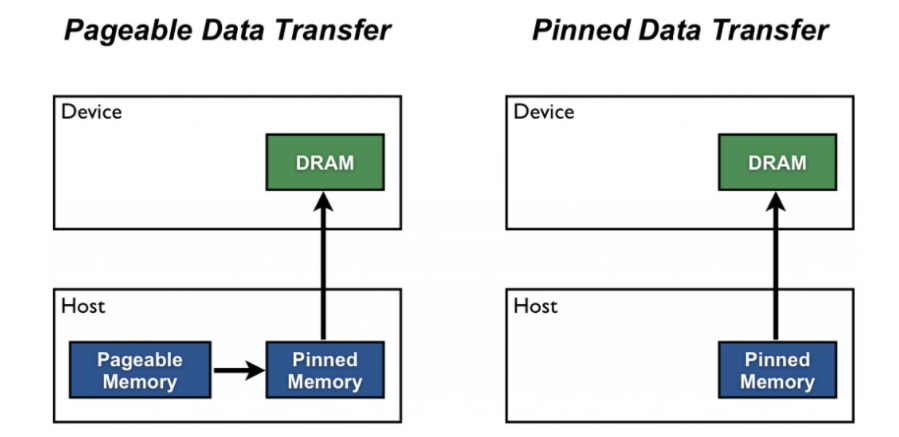

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

# Mô hình BERT

BERT là viết tắt của cụm từ **Bidirectional Encoder Representation from Transformer** có nghĩa là mô hình biểu diễn từ theo 2 chiều ứng dụng kỹ thuật Transformer. BERT được thiết kế để huấn luyện trước các biểu diễn từ (pre-train word embedding). Điểm đặc biệt ở BERT đó là nó có thể điều hòa cân bằng bối cảnh theo cả 2 chiều trái và phải.

Cơ chế attention của Transformer sẽ truyền toàn bộ các từ trong câu văn đồng thời vào mô hình một lúc mà không cần quan tâm đến chiều của câu. Do đó Transformer được xem như là huấn luyện hai chiều (bidirectional) mặc dù trên thực tế chính xác hơn chúng ta có thể nói rằng đó là huấn luyện không chiều (non-directional). Đặc điểm này cho phép mô hình học được bối cảnh của từ dựa trên toàn bộ các từ xung quanh nó bao gồm cả từ bên trái và từ bên phải.

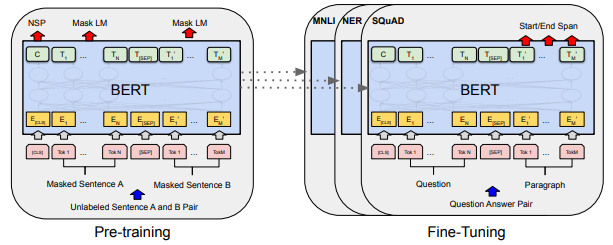

Toàn bộ tiến trình pre-training và fine-tuning của BERT. Một kiến trúc tương tự được sử dụng cho cả pretrain-model và fine-tuning model. Chúng ta sử dụng cùng một tham số pretrain để khởi tạo mô hình cho các tác vụ down stream khác nhau. Trong suốt quá trình fine-tuning thì toàn bộ các tham số của layers học chuyển giao sẽ được fine-tune. Đối với các tác vụ sử dụng input là một cặp sequence (pair-sequence) ví dụ như question and answering thì ta sẽ thêm token khởi tạo là [CLS] ở đầu câu, token [SEP] ở giữa để ngăn cách 2 câu.

Tiến trình áp dụng fine-tuning sẽ như sau:

Bước 1: Embedding toàn bộ các token của cặp câu bằng các véc tơ nhúng từ pretrain model. Các token embedding bao gồm cả 2 token là [CLS] và [SEP] để đánh dấu vị trí bắt đầu của câu hỏi và vị trí ngăn cách giữa 2 câu. 2 token này sẽ được dự báo ở output để xác định các phần Start/End Spand của câu output.

Bước 2: Các embedding véc tơ sau đó sẽ được truyền vào kiến trúc multi-head attention với nhiều block code (thường là 6, 12 hoặc 24 blocks tùy theo kiến trúc BERT). Ta thu được một véc tơ output ở encoder.

Bước 3: Để dự báo phân phối xác suất cho từng vị trí từ ở decoder, ở mỗi time step chúng ta sẽ truyền vào decoder véc tơ output của encoder và véc tơ embedding input của decoder để tính encoder-decoder attention (cụ thể về encoder-decoder attention là gì các bạn xem lại mục 2.1.1). Sau đó projection qua liner layer và softmax để thu được phân phối xác suất cho output tương ứng ở time step .

Bước 4: Trong kết quả trả ra ở output của transformer ta sẽ cố định kết quả của câu Question sao cho trùng với câu Question ở input. Các vị trí còn lại sẽ là thành phần mở rộng Start/End Span tương ứng với câu trả lời tìm được từ câu input.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
%%time
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 1)
model.to(device)
model.train()

Mô hình sử dụng id và mask từ token encoding trong tập train.

In [ ]:
%%time
for a in train_dataloader:
    ids = a['ids'].to(device)
    mask = a['mask'].to(device)
    output = model(ids, mask)
    break

In [ ]:
output

In [ ]:
func.softmax(output['logits'], dim = 1)

In [ ]:
output_probs = func.softmax(output['logits'], dim = 1)

In [ ]:
torch.max(output_probs, dim = 1)

# Chuẩn bị mô hình training và validating

## Cài đặt tham số

In [ ]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

Ta sử dụng tham số learning rate như đã thiết lập ở trên cho 10% tổng thời gian training. Sau đó, giảm dần learning rate về không.

In [ ]:
train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [ ]:
le = []
for b in tqdm(range(epochs)):
    for a in train_dataloader:
        le.append(scheduler.get_last_lr())
        scheduler.step()
plt.plot(np.arange(len(le)), le)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

## Hàm training

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/len(p_train)
    
    return losses, accuracy

**amp**: automatic mixed precision.

câu lệnh **with** được sử dụng trong xử lý ngoại lệ để làm cho mã sạch hơn và dễ đọc hơn nhiều. Nó đơn giản hóa việc quản lý các tài nguyên chung như các luồng tệp.

**Optimizer.step()**: thực hiện cập nhật tham số dựa trên gradient hiện tại (được lưu trữ trong thuộc tính .grad của tham số) và quy tắc cập nhật.

**Loss.backward()** gọi .backward() nhiều lần tích lũy gradient (bằng cách cộng) cho mỗi tham số. Đây là lý do tại sao ta nên gọi Optimizer.zero_grad() sau mỗi lần gọi .step().

## Hàm validating

Hàm validating khá giống với hàm training. Sự khác biệt là không có sự lan truyền ngược và tối ưu hóa cho các tham số trong đó.

In [ ]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/len(p_valid)
    
    return losses, accuracy, all_output_probs

# Train mô hình

In [ ]:
%%time

best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

In [ ]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 

# Đánh giá mô hình

Ta sử dụng auc để đánh giá.

In [ ]:
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = p_valid['target'].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [ ]:
auc(fpr, tpr)

# Phần 2

In [ ]:
%%time
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

train = pd.read_csv('../input/quora-insincere-questions-classification/train.csv', nrows = 50000)
test = pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
submission = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv')


def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


train['clean_text'] = train['question_text'].apply(str).apply(lambda x: clean_text(x))
test['clean_text'] = test['question_text'].apply(str).apply(lambda x: clean_text(x))

kfold = 5
train['kfold'] = train.index % kfold

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
max_len = 30

class BertDataSet(Dataset):
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)
    
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

epochs = 5
train_batch = 32
valid_batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/len(p_train)
    
    return losses, accuracy

def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/len(p_valid)
    
    return losses, accuracy, all_output_probs

Để cải thiện mô hình, ta lặp lại quy trình training tương tự cho mỗi lần gấp k-folds
# Lặp lại training cho K-fold

In [ ]:
%%time

best_scores = []
for fold in tqdm(range(0,5)):

    # initializing the data
    p_train = train[train['kfold'] != fold].reset_index(drop = True)
    p_valid = train[train['kfold'] == fold].reset_index(drop = True)

    train_dataset = BertDataSet(p_train['clean_text'], p_train['target'])
    valid_dataset = BertDataSet(p_valid['clean_text'], p_valid['target'])

    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle = True, num_workers = 4, pin_memory = True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, shuffle = False, num_workers = 4, pin_memory = True)

    model = transformers.BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = 1)
    model.to(device)
    
    LR = 2e-5
    optimizer = AdamW(model.parameters(), LR,betas = (0.9, 0.999), weight_decay = 1e-2) # AdamW optimizer

    train_steps = int(len(p_train)/train_batch * epochs)
    num_steps = int(train_steps * 0.1)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
    
    best_score = 1000
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_valid_probs = []
    
    print("-------------- Fold = " + str(fold) + "-------------")
    
    for epoch in tqdm(range(epochs)):
        print("Epoch = " + str(epoch))

        train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
        valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        
        print('train losses: %.4f' %(train_loss), 'train accuracy: %.3f' %(train_acc))
        print('valid losses: %.4f' %(valid_loss), 'valid accuracy: %.3f' %(valid_acc))

        if (valid_loss < best_score):

            best_score = valid_loss
            print("Found an improved model! :)")

            state = {'state_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'best_score':best_score
                    }

            torch.save(state, "model" + str(fold) + ".pth")
            best_valid_prob = valid_probs
            torch.cuda.memory_summary(device = None, abbreviated = False)
        else:
            pass


    best_scores.append(best_score)
    best_valid_probs.append(best_valid_prob)
    
    ##Plotting the result for each fold
    x = np.arange(epochs)
    fig, ax = plt.subplots(1, 2, figsize = (15,4))
    ax[0].plot(x, train_losses)
    ax[0].plot(x, valid_losses)
    ax[0].set_ylabel('Losses', weight = 'bold')
    ax[0].set_xlabel('Epochs')
    ax[0].grid(alpha = 0.3)
    ax[0].legend(labels = ['train losses', 'valid losses'])

    ax[1].plot(x, train_accs)
    ax[1].plot(x, valid_accs)
    ax[1].set_ylabel('Accuracy', weight = 'bold')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(labels = ['train acc', 'valid acc'])

    ax[1].grid(alpha = 0.3)
    fig.suptitle('Fold = '+str(fold), weight = 'bold') 

In [ ]:
best_scores

In [ ]:
print('Mean of',kfold, 'folds for best loss in', epochs, 'epochs cross-validation folds is %.4f.' %(np.mean(best_scores)))

# Đánh giá cho k mô hình
Ta sử dụng tập hợp để đánh giá k mô hình trong validation set

In [ ]:
def predicting(test_dataloader, model, pthes):
    allpreds = []
    
    for pth in pthes:
        state = torch.load(pth)
        model.load_state_dict(state['state_dict'])
        model.to(device)
        model.eval()
        preds = []
        with torch.no_grad():
            for a in test_dataloader:
                ids = a['ids'].to(device)
                mask = a['mask'].to(device)
                output = model(ids, mask)
                output = output['logits'].squeeze(-1)
                output_probs = torch.sigmoid(output)
                preds.append(output_probs.cpu().numpy())
            preds = np.concatenate(preds)
            allpreds.append(preds)
      
    return allpreds

In [ ]:
pthes = [os.path.join("./",s) for s in os.listdir("./") if ".pth" in s]
pthes

In [ ]:
allpreds = predicting(valid_dataloader, model, pthes)

Lấy trung bình của xác suất từ k-mô hình cho mỗi mẫu trong tập validation.

In [ ]:
valid_probs = np.zeros(len(p_valid))
for i in range(kfold):
    valid_probs += allpreds[i]
valid_probs = valid_probs / kfold

In [ ]:
valid_probs = np.asarray(valid_probs).flatten()

In [ ]:
#valid_probs = allpreds[0].flatten() #This line is used when training for one model and not k-fold model 
y_valid = p_valid['target'].to_numpy().flatten()

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, valid_probs)
print('auc score for kfold =', kfold, 'models is: %.2f' %(auc(fpr, tpr)*100))

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curv')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

In [ ]:
class BERTinferenceDataSet(Dataset):
    
    def __init__(self, sentences):
        self.sentences = sentences

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_sent = tokenizer.encode_plus(sentence, 
                                         add_special_tokens = True, #[SEP][PAD]
                                         max_length = max_len,
                                         pad_to_max_length = True,
                                         truncation = True)

        ids = torch.tensor(bert_sent['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_sent['attention_mask'], dtype = torch.long)

        return{
            'ids' : ids,
            'mask' : mask
             }

In [ ]:
test_batch = 32
test_dataset = BERTinferenceDataSet(test['clean_text'])
test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle = False, num_workers = 4, pin_memory = True)
pthes

In [ ]:
allpreds = predicting(test_dataloader, model, pthes)

In [ ]:
allpreds[0][0]

In [ ]:
preds = np.zeros(len(test_dataset))
for i in range(kfold):
    preds += allpreds[i]
preds = preds / kfold

In [ ]:
results = pd.DataFrame(preds)
submission = pd.concat([test,results], axis = 1).drop(['question_text', 'clean_text'], axis = 1)
submission.rename(columns = { 0:'target'}, inplace = True)
submission.to_csv("submission.csv", index = False)